# Quantum Imaginary Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import Statevector
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools import parallel_map

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
def normalize_counts(counts):
    total=sum(counts.values())
    for state in counts:
        counts[state] = counts[state]/total
    return counts

def graycode_statvector_circuit(n_qubits):
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
    
    if n_qubits==2:
        thetas=np.array([1,2,np.pi/4])
    elif n_qubits==3:
        thetas=np.array([1,2,np.pi/4,np.pi/2,np.pi/6,np.pi/3,np.pi])
    else:
        print(f"need to implement thetas for {n_qubits} qubits")

    circuit=initialize_circuit(q,c,"single_state","gray_code")
    
    circuit=append_Gray_code_variational_ansatz(circuit,q,thetas)
    return circuit


def graycode_qasm_circuit(n_qubits,num_cnot_pairs,num_folds):
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
    
    if n_qubits==2:
        thetas=np.array([1,2,np.pi/4])
    elif n_qubits==3:
        thetas=np.array([1,2,np.pi/4,np.pi/2,np.pi/6,np.pi/3,np.pi])
    else:
        print(f"need to implement thetas for {n_qubits} qubits")
    circuit=initialize_circuit(q,c,"single_state","gray_code")
    
    circuit=append_Gray_code_variational_ansatz(circuit,q,thetas,num_cnot_pairs=num_cnot_pairs)
    circuit=fold_circuit(circuit,num_folds)
    circuit.measure(q,c)

    return circuit

def excecute_qasm_circuit(circuit,device,n_shots,normalize=True):
    backend='qasm_simulator'
    if device is not None:
        job = execute(circuit, Aer.get_backend(backend),
                    shots=n_shots,
                    noise_model=device.noise_model,
                    basis_gates=device.noise_model.basis_gates,
                    coupling_map=device.coupling_map,
                    initial_layout=device.layout,
                    optimization_level=0
                 )
        
        counts=job.result().get_counts(circuit)
        
        if device.meas_filter:
            counts = device.meas_filter.apply(counts)
    else:
        job = execute(circuit, Aer.get_backend(backend),shots=n_shots)
        counts=job.result().get_counts(circuit)
        
    if normalize:
        counts = normalize_counts(counts)
    return counts


def get_exact_values(n_qubits,n_shots):
    """
    Get exact values for given number of qubits 
    """
    backend = 'statevector_simulator'
    device=None
    
    
    circuit=graycode_statvector_circuit(n_qubits)
    job = execute(circuit, Aer.get_backend(backend),shots=16)
    psi=job.result().get_statevector(circuit)
    state_vector=Statevector(psi)
    counts=state_vector.to_counts()
    return counts

def generate_counts_table(
    n_qubits,n_shots,extrapolation_type, num_extrapolation_steps, device_name,mitigate_meas_error
    ):
    """
    Generate dicionary giving counts for each state for number of extrapolation states ranging 
    from 0 to num_extrapolation_steps in steps of 1
    
    Returns:
        counts_table (dictionary) : {state : array[counts for each extrap step]}
    """
    device = Device(device_name, mitigate_meas_error=mitigate_meas_error, N_qubits=n_qubits, layout=None)
#     backend = 'qasm_simulator'

    ## Get list of all possible states for n_qubits
    states=gray_code(n_qubits)
    
    ## Initialize table
    ## By state, by num_extrapolation_steps
    counts_table={}
    for state in states:
        counts_table[state]=np.zeros(num_extrapolation_steps)
    
    for num in range(0,num_extrapolation_steps,1):
        num_cnot_pairs,num_folds=0,0
        
        if extrapolation_type == "CNOT":
            num_cnot_pairs=num
        elif extrapolation_type == "Folding":
            num_folds=num
            
        circuit=graycode_qasm_circuit(n_qubits,num_cnot_pairs=num_cnot_pairs,num_folds=num_folds)
#         print(circuit.draw())
        counts=excecute_qasm_circuit(circuit,device,n_shots)
        
        for state in counts:
            counts_table[state][num]=counts[state]

    return counts_table


## Reorganize counts_table data for plotting 
def reorganize_counts_table(counts_table):
    """
    Reorganized counts_table (list of dictionaries {state : array[counts for each extrap step]}) into 
    dictionary of {state: 2D array by extrapolation step by trial index}
    """
    reorganized_counts_table={}
    num_trials=len(counts_table)

    ## Zero initialize table    
    for state in counts_table[0]:
        num_extrapolation_steps=len(counts_table[0][state])
        reorganized_counts_table[state]=[None]*num_extrapolation_steps
        for estep in range(num_extrapolation_steps):
            reorganized_counts_table[state][estep]=np.zeros(num_trials)

    ## Reorganize the data
    for i in range(num_trials):
        for state in counts_table[i]:
            for estep in range(num_extrapolation_steps):
                reorganized_counts_table[state][estep][i]=counts_table[i][state][estep]
    
    return reorganized_counts_table


def extrapolate_counts(
    counts_table,
    num_extrapolation_steps=1,
    poly_degree=1,
    normalize=False
):
    """
    Extrapolates values for each state in counts table
    """    
    extrapolated_counts={}
    ## If num_extrapolation_steps==0, the don't do extrapolation
    if num_extrapolation_steps==0:
        for state in counts_table:
            extrapolated_counts[state]=counts_table[state][0]
        
    else:
        
        if num_extrapolation_steps > len(list(counts_table.values())[0]):
            print("insufficient data to extrapolate {} steps".format(num_extrapolation_steps))
        x_values=[2*n+1 for n in range(num_extrapolation_steps+1)]
        for state in counts_table:
            y_values=counts_table[state][:num_extrapolation_steps+1]
#             print(num_extrapolation_steps,y_values)
            coef=np.polyfit(x_values,y_values,poly_degree)
            linear_fit=np.poly1d(coef)
            extrapolated_counts[state]=linear_fit(0)
    
    if normalize:
        return normalize_counts(extrapolated_counts)
    else:
        return extrapolated_counts

def get_plot_indices(num_rows,num_cols,state_index):
    i=int(state_index//num_cols)
    j=int(state_index%num_cols)
    return(i,j)



def get_extrapolation_statistics(n_qubits,counts_table,max_poly_degree,num_extrapolation_steps,num_trials,verbose=True):
    states=gray_code(n_qubits)
    
    ## Initialize data container 
    extrapolation_data={}
    for state in states:
        extrapolation_data[state]=[None]*max_poly_degree
        for poly_degree in range(1,max_poly_degree+1,1):
            extrapolation_data[state][poly_degree-1]=[None]*num_extrapolation_steps
            for num in range(num_extrapolation_steps):
                extrapolation_data[state][poly_degree-1][num]=np.zeros(num_trials)

    for i in range(num_trials):    
        ## Using a given number of points determined by num_steps, 
        ## fit polynomial of degree poly_degree and extrapolate    
        for poly_degree in range(1,max_poly_degree+1): 
            for num_steps in range(num_extrapolation_steps):
                counts=extrapolate_counts(counts_table[i],num_steps,poly_degree)
                for state in counts:
                    extrapolation_data[state][poly_degree-1][num_steps][i]=counts[state]
    
    if verbose:
        print(f"state   n   poly   mean     stdv")
                
    ## Generate statistics for extrapolations (average over trials )
    extrapolation_values={}
    for state in states:
        extrapolation_values[state]={}
        for poly_degree in range(1,max_poly_degree+1,1):
            extrapolation_values[state][poly_degree]=[None]*num_extrapolation_steps
            for num in range(num_extrapolation_steps):
                values=extrapolation_data[state][poly_degree-1][num]
                extrapolation_values[state][poly_degree][num]=(np.mean(values),np.std(values))            
                if verbose:
                    print(f"  {state:3}   {num}   {poly_degree:2}    {np.mean(values):6.4f}   {np.std(values):6.4f}")
    return extrapolation_values

def plot_extrapolation_of_averages(counts_table,num_extrapolation_steps,ymin_ymax_values):
    """
    Takes average of counts obtained in different trials
    
    Plots:
        Counts for each qubit state, for each extrapolation step averaged over number of trials
        Standard deviation of counts for each qubit state, for each extrapolation step 
        Polynomial fits corresponding to averages over trails for each qubit state (x^n for n=1,2,3)
    """
    ## Plotting different fits for data
    x_values=np.array([2*i+1 for i in range(num_extrapolation_steps)])
   
    ## Number of qubits given by length of one of the qubit state strings
    n_qubits=len(next(iter(counts_table)))
    
    ## number of rows and columns in the plot
    num_rows=n_qubits
    num_states=len(counts_table)
    num_cols=int(np.ceil(num_states/n_qubits))

    fig=plt.figure()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    spec=gridspec.GridSpec(ncols=num_cols, nrows=num_rows, figure=fig)
    props = dict(boxstyle='round', facecolor='white')

    
    colors=["b","g","r","c","m"]
    
    state_index=0
    for state in counts_table:
        y_values=np.mean(np.array(counts_table[state]),axis=1)
        y_errors=np.std(np.array(counts_table[state]),axis=1)

        i,j=get_plot_indices(num_rows,num_cols,state_index)
        subfig=fig.add_subplot(spec[i,j])
        ## Plot values with errors
        subfig.errorbar(x_values, y_values, yerr=y_errors, capsize=4, fmt='ko',label="")
        ## Plot exact values
        subfig.plot(list(range(0,x_values[-1]+2)), np.repeat(exact_counts[state],x_values[-1]+2), '--k')
        
        ## Plot extrapolations
        for poly_degree in range(1,4,1):
            color=colors[poly_degree]
            coef,residules,_,_,_=np.polyfit(x_values,y_values,poly_degree,full=True)
            linear_fit=np.poly1d(coef)
            x=np.arange(0.0, 2*num_extrapolation_steps+1, 0.01)
            subfig.plot(x,linear_fit(x),color,label=f"p={poly_degree}   R={residules[0]:3.1e}")        
            
            subfig.plot(list(range(0,x_values[-1]+2)), np.repeat(linear_fit(0),x_values[-1]+2), '--'+color)
            
        ## Adjust y plot ranges
        if state in ymin_ymax_values: 
            ymin_ymax=ymin_ymax_values[state]
        else:
            ymin_ymax=[0,1]
        plt.ylim(ymin_ymax)
        plt.xlim(0,x_values[-1]+1)

        subfig.legend(prop={'size': 12})

        ## Reposition state labels
        if n_qubits==2:
            state_label_position=(0.5, 0.95)
        elif n_qubits==3:
            state_label_position=(0.05, 0.95)

        subfig.text(state_label_position[0], state_label_position[1], f"{state}", 
            transform=subfig.transAxes, fontsize=20,verticalalignment='top', bbox=props)

        plt.xlabel("2n+1")
        plt.ylabel("Probability")

        state_index+=1

In [3]:
exact_counts=get_exact_values(n_qubits=3,n_shots=1000)

In [4]:
counts_table=[generate_counts_table(
                n_qubits=3,n_shots=10000,extrapolation_type="CNOT", num_extrapolation_steps=2,
                device_name='ibmq_vigo',mitigate_meas_error=True
                )]
print(counts_table)

reorganized_counts_table=reorganize_counts_table(counts_table)
print()
print(reorganized_counts_table)

[{'000': array([0.1049577, 0.1039922]), '001': array([0.15252222, 0.15497279]), '011': array([0.00209559, 0.00824698]), '010': array([0.32230339, 0.31039681]), '110': array([0.00980125, 0.02033553]), '111': array([0.15250046, 0.16206808]), '101': array([0.17388607, 0.16430624]), '100': array([0.08193331, 0.07568137])}]

{'000': [array([0.1049577]), array([0.1039922])], '001': [array([0.15252222]), array([0.15497279])], '011': [array([0.00209559]), array([0.00824698])], '010': [array([0.32230339]), array([0.31039681])], '110': [array([0.00980125]), array([0.02033553])], '111': [array([0.15250046]), array([0.16206808])], '101': [array([0.17388607]), array([0.16430624])], '100': [array([0.08193331]), array([0.07568137])]}


In [5]:
n_qubits=3
n_shots=10000
# extrapolation_type="CNOT"
extrapolation_type="Folding"
num_extrapolation_steps=5
device_name='ibmq_vigo'

num_trials=100
max_poly_degree=1

## By state, by number of folds or cnot pairs 
counts_table=[None]*num_trials
for i in range(num_trials):
    counts_table[i]=generate_counts_table(n_qubits,n_shots,extrapolation_type,num_extrapolation_steps,device_name,True)
      

Number of trials 100


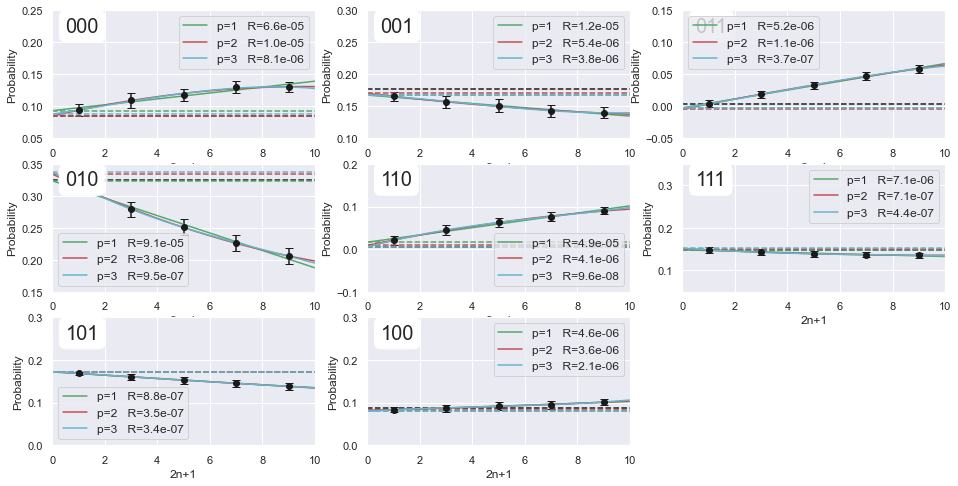

In [6]:
## Plotting different fits for data
print(f"Number of trials {num_trials}")
ymin_ymax_values={
    "000":[0.05,0.25],"001":[0.1,0.3],"011":[-0.05,0.15],"010":[0.15,0.35],
    "110":[-0.1,0.2],"111":[0.05,0.35],"101":[0.0,0.3],"100":[0.0,0.3]
    }
reorganized_counts_table=reorganize_counts_table(counts_table)
plot_extrapolation_of_averages(reorganized_counts_table,num_extrapolation_steps,ymin_ymax_values)



Number of trials 100


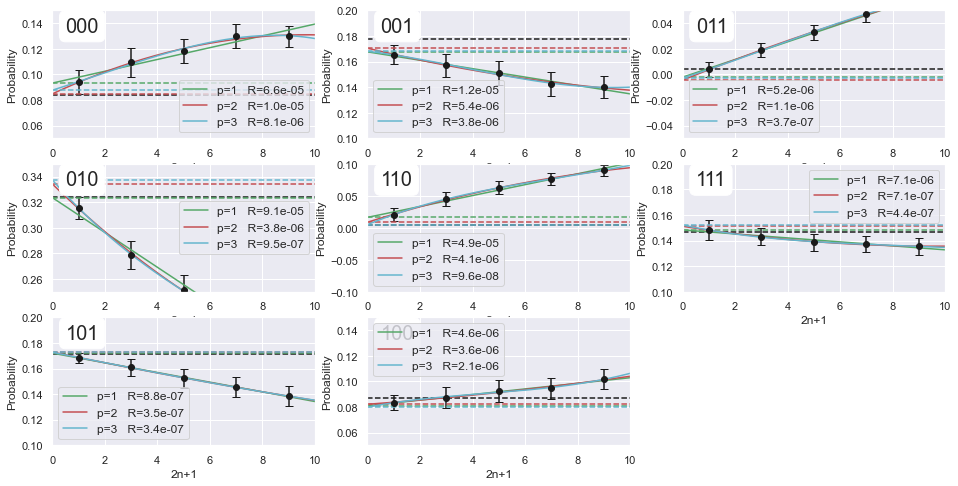

In [7]:
## Plotting different fits for data
print(f"Number of trials {num_trials}")
ymin_ymax_values={
    "000":[0.05,0.15],"001":[0.1,0.2],"011":[-0.05,0.05],"010":[0.25,0.35],
    "110":[-0.1,0.1],"111":[0.1,0.2],"101":[0.1,0.2],"100":[0.05,0.15]
    }
reorganized_counts_table=reorganize_counts_table(counts_table)
plot_extrapolation_of_averages(reorganized_counts_table,num_extrapolation_steps,ymin_ymax_values)



In [8]:
# plot_extrapolation_of_averages(reorganized_counts_table,num_extrapolation_steps,ymin_ymax_values)

def plot_extrapolations_for_diff_num_steps(counts_table,num_extrapolation_steps,poly_degree,ymin_ymax_values={}):
    """
    for fixed polynomial degree, look at extrapolations for different number of extrapolation steps 
    """
    print(f"Extrapolation polynomial degree = {poly_degree}")
    print("s is the number of data points included in fit")

    num_trials=len(counts_table)
    
    ## Get reorganized table of counts for plotting 
    reorganized_counts_table=reorganize_counts_table(counts_table)
    n_qubits=len(list(reorganized_counts_table.keys())[0])

    ## Get extrapolated values 
    extrapolation_values=get_extrapolation_statistics(n_qubits,counts_table,poly_degree,
                            num_extrapolation_steps,num_trials,verbose=False)

    fig=plt.figure(figsize=(20, 30))
#     fig=plt.figure()
#     fig.tight_layout(pad=2)
#     plt.subplots_adjust(wspace=0.5, hspace=0.2)
    num_cols=num_extrapolation_steps-poly_degree
    spec=gridspec.GridSpec(ncols=num_cols, nrows=len(reorganized_counts_table), figure=fig,wspace=.2,hspace=.2)

    props = dict(boxstyle='round', facecolor='white')
    colors=["b","g","r","c","m"]
    
    x_values=np.array([2*i+1 for i in range(num_extrapolation_steps)])
    state_counter=0
    for state in reorganized_counts_table:
        ## Plot same raw data for each state on each extrapolation plot
        y_values=np.mean(np.array(reorganized_counts_table[state]),axis=1)
        y_errors=np.std(np.array(reorganized_counts_table[state]),axis=1)

        ## Adjust y plot ranges
        if state in ymin_ymax_values: 
            ymin_ymax=ymin_ymax_values[state]
        else:
            ymin_ymax=[0,1]
            

        color_index=0
        for num in range(poly_degree,num_extrapolation_steps):
            subfig=fig.add_subplot(spec[state_counter,color_index])
#             plt.subplots(figsize=(20, 10)
            ## Exact value
            subfig.plot(list(range(0,x_values[-1]+2)), np.repeat(exact_counts[state],x_values[-1]+2), '--k')
            ## Data points
            subfig.errorbar(x_values, y_values, yerr=y_errors, capsize=4, fmt='ko',label="")
            ## Extrapolated values
            (y,error)=extrapolation_values[state][poly_degree][num]
            subfig.plot(x,[y]*len(x),"{}".format(colors[color_index]),label="{}".format(num))
            subfig.plot(x,[y-error]*len(x),"{}-.".format(colors[color_index]))
            subfig.plot(x,[y+error]*len(x),"{}-.".format(colors[color_index]))
            
            subfig.text(0.86, 0.86, f"{state}\n s={num+1}", transform=subfig.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)

            
            plt.ylim(ymin_ymax)
            plt.xlim(0,x_values[-1]+1)

            
            color_index+=1
                           
        state_counter+=1
    
    
##############################################################################################################

Extrapolation polynomial degree = 1
s is the number of data points included in fit


NameError: name 'x' is not defined

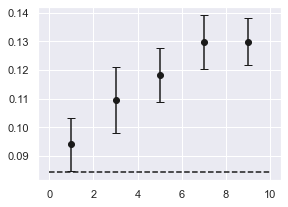

In [9]:
poly_degree=1
ymin_ymax_values={
    "000":[0.05,0.25],"001":[0.1,0.3],"011":[-0.05,0.15],"010":[0.15,0.35],
    "110":[-0.1,0.2],"111":[0.05,0.35],"101":[0.0,0.3],"100":[0.0,0.3]
    }
plot_extrapolations_for_diff_num_steps(counts_table,num_extrapolation_steps,poly_degree,ymin_ymax_values)

In [ ]:
poly_degree=2
ymin_ymax_values={
    "000":[0.05,0.25],"001":[0.1,0.3],"011":[-0.05,0.15],"010":[0.15,0.35],
    "110":[-0.1,0.2],"111":[0.05,0.35],"101":[0.0,0.3],"100":[0.0,0.3]
    }

plot_extrapolations_for_diff_num_steps(counts_table,num_extrapolation_steps,poly_degree,ymin_ymax_values)


In [ ]:
n_qubits=3
n_shots=10000
extrapolation_type="CNOT"
num_extrapolation_steps=5
device_name='ibmq_vigo'

num_trials=100
# num_trials=10
max_poly_degree=1

## By state, by number of folds or cnot pairs 
counts_table_ne=[None]*num_trials
for i in range(num_trials):
    counts_table_ne[i]=generate_counts_table(n_qubits,n_shots,extrapolation_type,num_extrapolation_steps,device_name,False)

In [ ]:
## Plotting different fits for data
print(f"Number of trials {num_trials}")
ymin_ymax_values={
    "000":[0.05,0.25],"001":[0.1,0.3],"011":[-0.05,0.15],"010":[0.15,0.35],
    "110":[-0.1,0.2],"111":[0.05,0.35],"101":[0.0,0.3],"100":[0.0,0.3]
    }
reorganized_counts_table_ne=reorganize_counts_table(counts_table_ne)
plot_extrapolation_of_averages(reorganized_counts_table_ne,num_extrapolation_steps,ymin_ymax_values)

In [ ]:
## averaging over different number of trials 


In [ ]:
poly_degree=1
ymin_ymax_values={
    "000":[0.05,0.25],"001":[0.1,0.3],"011":[-0.05,0.15],"010":[0.15,0.35],
    "110":[-0.1,0.2],"111":[0.05,0.35],"101":[0.0,0.3],"100":[0.0,0.3]
    }

plot_extrapolations_for_diff_num_steps(counts_table_ne,num_extrapolation_steps,poly_degree,ymin_ymax_values)
